In [493]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [494]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv')

In [495]:
listings_df.head()

,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_date,year_of_construction,price
0,2 storey,1191,4076,3,1,2,Beauport,2020-12-01,2004,332500
1,Unknown,1645,1360,3,1,3,Mercier,2021-11-01,2006,612000
2,Link,2024,17000,4,3,1,Stoneham,2021-12-01,2019,526500
3,2 storey,2400,4471,4,2,2,Gatineau,2021-12-01,1989,360000
4,Unknown,1800,16090,5,2,2,Alma,2021-09-01,4808,284000


## Adding columns

In [496]:
listings_df.insert(7, 'year', '')
listings_df['year'] = pd.DatetimeIndex(listings_df['listing_date']).year

## Correlation Heat Map

In [497]:
sns.set_theme(style="white")

def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

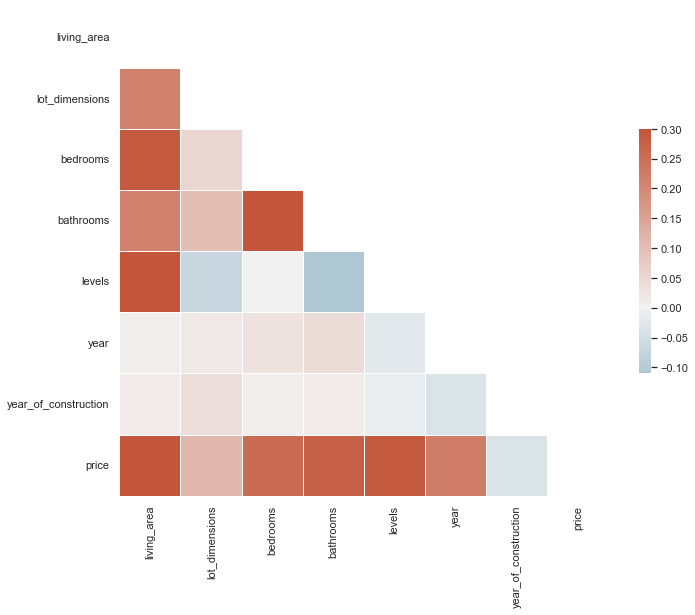

In [498]:
plot_corr_map(listings_df)

## Choosing columns

In [499]:
ordinal_cols = ['location', 'year']
one_hot_cols = ['bedrooms', 'bathrooms']
numerical_cols = ['living_area', 'lot_dimensions']
target_col = ['price']

In [500]:
listings_df = listings_df[ordinal_cols + one_hot_cols + numerical_cols + target_col]

## One Hot Encoding

In [501]:
def oh_encode(df_line, col, new_col, val):
    if df_line[col] == val:
        return df_line[new_col] + 1
    else:
        return df_line[new_col]

for col in one_hot_cols:
    for val in listings_df[col].unique():   
        new_col = str(val) + '_' + col
        listings_df[new_col] = 0
        listings_df[new_col] = listings_df.apply(oh_encode, args=(col, new_col, val), axis=1)

    listings_df = listings_df.drop(columns=[col])

In [502]:
listings_df.head()

,location,year,living_area,lot_dimensions,price,3_bedrooms,4_bedrooms,5_bedrooms,6_bedrooms,2_bedrooms,1_bedrooms,1_bathrooms,3_bathrooms,2_bathrooms,4_bathrooms
0,Beauport,2020,1191,4076,332500,1,0,0,0,0,0,1,0,0,0
1,Mercier,2021,1645,1360,612000,1,0,0,0,0,0,1,0,0,0
2,Stoneham,2021,2024,17000,526500,0,1,0,0,0,0,0,1,0,0
3,Gatineau,2021,2400,4471,360000,0,1,0,0,0,0,0,0,1,0
4,Alma,2021,1800,16090,284000,0,0,1,0,0,0,0,0,1,0


## Spliting Data

In [503]:
y = listings_df[target_col]
X = listings_df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Ordinal Encoding

In [504]:
ordinal_encoders = {}

for col in ordinal_cols:
    ordinal_encoders[col] = OrdinalEncoder()
    X_train[col] = ordinal_encoders[col].fit_transform(X_train[[col]])
    X_test[col] = ordinal_encoders[col].transform(X_test[[col]])

## Scaling

In [505]:
# scalers = {}

# for col in numerical_cols:
#     scalers[col] = MinMaxScaler()
#     X_train[col] = scalers[col].fit_transform(X_train[[col]])
#     X_test[col] = scalers[col].transform(X_test[[col]])

In [506]:
scale_target = False

if scale_target:
    target_scaler = MinMaxScaler()

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.fit_transform(y_test)

In [507]:
X_train.head()

,location,year,living_area,lot_dimensions,3_bedrooms,4_bedrooms,5_bedrooms,6_bedrooms,2_bedrooms,1_bedrooms,1_bathrooms,3_bathrooms,2_bathrooms,4_bathrooms
33706,64.0,5.0,1160,8000,1,0,0,0,0,0,0,0,1,0
1889,46.0,13.0,1050,8409,1,0,0,0,0,0,0,0,1,0
24390,17.0,8.0,1614,8125,0,1,0,0,0,0,0,0,1,0
22221,59.0,9.0,1175,5424,0,0,0,0,1,0,1,0,0,0
14741,37.0,11.0,1560,4304,0,1,0,0,0,0,1,0,0,0


In [508]:
y_train

,price
33706,380000
1889,353000
24390,309000
22221,182000
14741,380000
...,...
6265,450000
11284,252000
38158,359000
860,241000


In [509]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.4007353978010646